In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import MACCSkeys
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
import math
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from rdkit.Chem.SaltRemover import SaltRemover
from sklearn import model_selection as ms

In [2]:
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras import layers

C:\ProgramData\Miniconda3\envs\cdd2018\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Priprava dat

In [3]:
def Nacti(_soubor):
    newData = []
    counter = 0
    with open(_soubor, "r") as f:
        next (f)
        for line in f:
            radek = line.strip().split("\t")
            try:
                    radek = (radek[0],Chem.MolFromSmiles(radek[10]),-math.log10(float((radek[14]))))
                    newData.append(radek)                    
            except ValueError:
                counter += 1
    print("prazdne: " + str(counter))
    return newData

allRes=[0]*7
def outStat(_model, _name):
    r2 = _model.score(xTest, yTest)
    corr = np.corrcoef(_model.predict(xTest), yTest)[0][1]
    mse = mean_squared_error(_model.predict(xTest), yTest)
    df = pd.DataFrame([[_name, r2, corr, mse]], columns=["name", "R^2", "correlation", "MSE"])
    return df
    
def plot2(_yTrain, _xTrain, _yTest, _xTest, _model,_title = ""):
    plt.style.use('ggplot')
    plt.figure(figsize=(15,10))
    plt.scatter(_yTrain,_model.predict(_xTrain), label = 'Train')
    plt.title(_title)
    plt.xlabel('Original activity')
    plt.ylabel('Predicted activity')
    plt.scatter(_yTest,_model.predict(_xTest), label='Test', alpha = 0.8)
    plt.legend(loc=4)
    plt.show()

In [4]:
soubor = "../Projekt/Data/GlucocorticoidReceptor.txt"

In [5]:
mols = Nacti(soubor)
sortedMols = sorted(mols, key=lambda stdVal: stdVal[2])
pvals = [val[2] for val in sortedMols]
#Draw.MolToImage(sortedMols[0][1])

prazdne: 981


In [6]:
#odstraneni soli

In [7]:
remover = SaltRemover(defnData='[!C;!c;!#7;!#8;!#16;!Cl;!F;!Br;!I]')
remover2 = SaltRemover()

In [8]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions = _InitialiseNeutralisationReactions()
        reactions = _reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol

In [9]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
_carbonPatt = Chem.MolFromSmarts("[#6]")

def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [10]:
cleanMols = [sm for sm in (standardize(m[1]) for m in sortedMols if m) if sm]

In [11]:
counter = -1
cleanMols = []
poleOdstranenych = []
for mol in sortedMols:
    counter += 1    
    if standardize(mol[1]):
        cleanMols.append(standardize(mol[1]))
    else:
        poleOdstranenych.append(counter)


In [12]:
for i in range(len(poleOdstranenych)):
 pvals.pop(poleOdstranenych[i])


In [13]:
#fingerprinty

In [14]:
mqns = [rdMolDescriptors.MQNs_(mol) for mol in cleanMols]
maccs = [MACCSkeys.GenMACCSKeys(mol) for mol in cleanMols]
morgFPs = [Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) for mol in cleanMols]
fpsMol = [Fingerprinter.FingerprintMol(mol) for mol in cleanMols]

In [15]:
len(mqns), len(pvals), len(sortedMols), len(cleanMols)
#Draw.MolToImage(sortedMols[0][1])
#Draw.MolToImage(cleanMols[0])

(2763, 2763, 2768, 2763)

# _______________________________________________

# predikce na vsech datech

# MQN - random forest

In [16]:
xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(mqns, pvals, test_size = 0.25, random_state = 7)

In [17]:
rndForestReg = ensemble.RandomForestRegressor()
rndForestReg.fit(xTrain,yTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

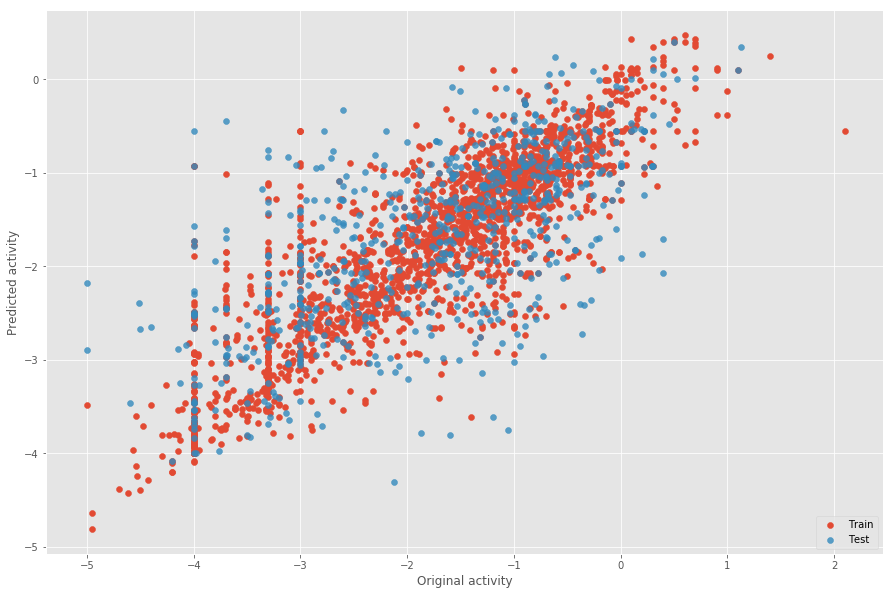

In [18]:
plot2(yTrain, xTrain, yTest, xTest, rndForestReg)

In [19]:
allRes[0] = (outStat(rndForestReg, "rndForMQN"))
allRes[0]

,name,R^2,correlation,MSE
0,rndForMQN,0.412634,0.655801,0.82025


# ________________________________________________________

# MQN - SVM

In [20]:
svm = svm.SVR()
svm.fit(xTrain,yTrain)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

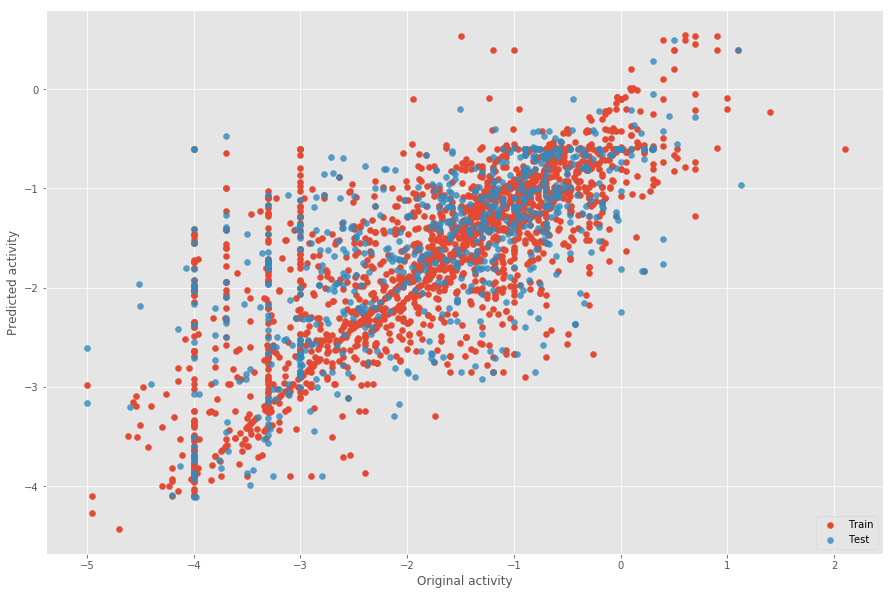

In [21]:
plot2(yTrain, xTrain, yTest, xTest, svm)

In [22]:
allRes[1] = (outStat(svm, "svmMQN"))
allRes[1]

,name,R^2,correlation,MSE
0,svmMQN,0.453639,0.682751,0.762987


# ________________

# MACC - random forest

In [23]:
xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(maccs, pvals, test_size = 0.25, random_state = 7)

In [24]:
rndForestReg = ensemble.RandomForestRegressor()
rndForestReg.fit(xTrain,yTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

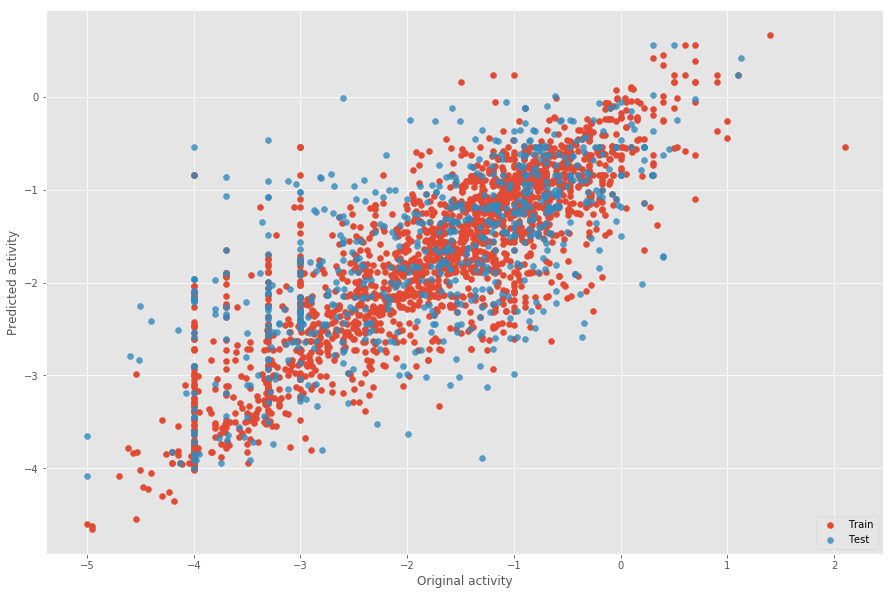

In [25]:
plot2(yTrain, xTrain, yTest, xTest, rndForestReg)

In [26]:
allRes[2] = outStat(rndForestReg, "rndForMACC")
allRes[2]

,name,R^2,correlation,MSE
0,rndForMACC,0.450665,0.679516,0.76714


# __________________________________________________________

# MACC - SVM

In [27]:
from sklearn import svm
from sklearn.svm import SVC

In [28]:
svm = svm.SVR()
svm.fit(xTrain,yTrain)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

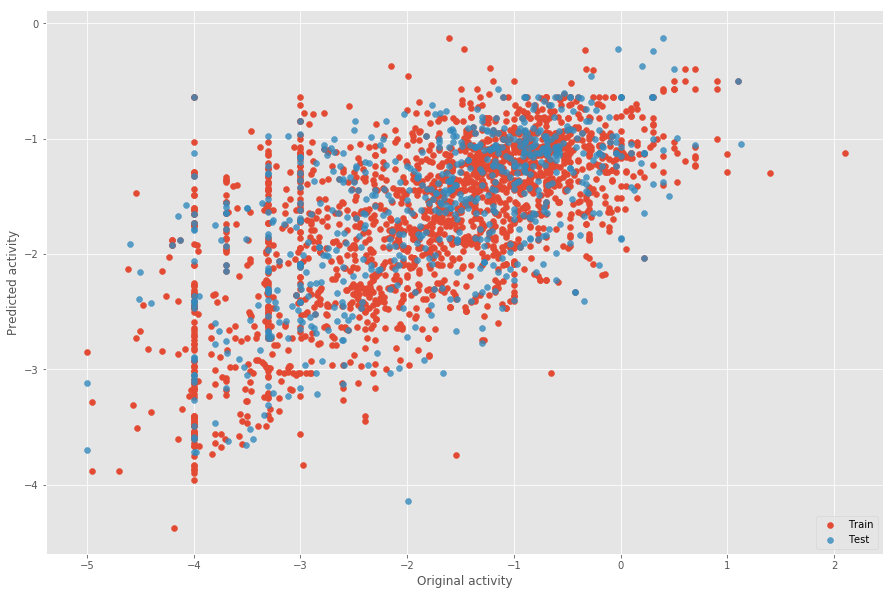

In [29]:
plot2(yTrain, xTrain, yTest, xTest, svm)

In [30]:
allRes[3] = outStat(svm, "svmMACC")
allRes[3]

,name,R^2,correlation,MSE
0,svmMACC,0.372119,0.622104,0.876828


# ________________________________________________________

# MORGAN fingerprint - random forest

In [31]:
xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(morgFPs, pvals, test_size = 0.25, random_state = 7)

In [32]:
rndForestReg = ensemble.RandomForestRegressor()
rndForestReg.fit(xTrain,yTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

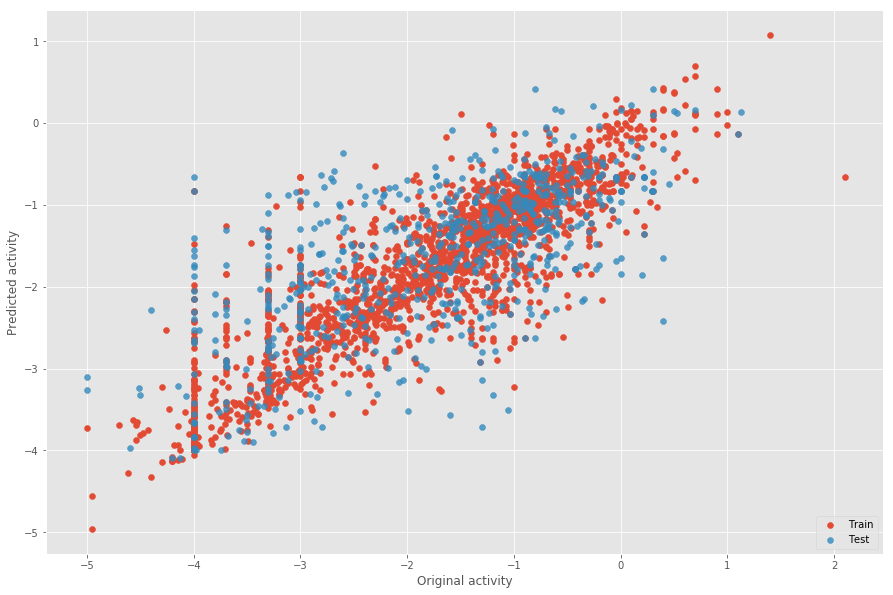

In [33]:
plot2(yTrain, xTrain, yTest, xTest, rndForestReg)

In [34]:
allRes[4] = outStat(rndForestReg, "rndForMorgan")
allRes[4]

,name,R^2,correlation,MSE
0,rndForMorgan,0.427196,0.668259,0.799914


# __________________________________________________________

# MORGAN fingerprint - SVM

In [35]:
from sklearn.svm import SVC
from sklearn import svm

In [36]:
svm = svm.SVR()
svm.fit(xTrain,yTrain)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

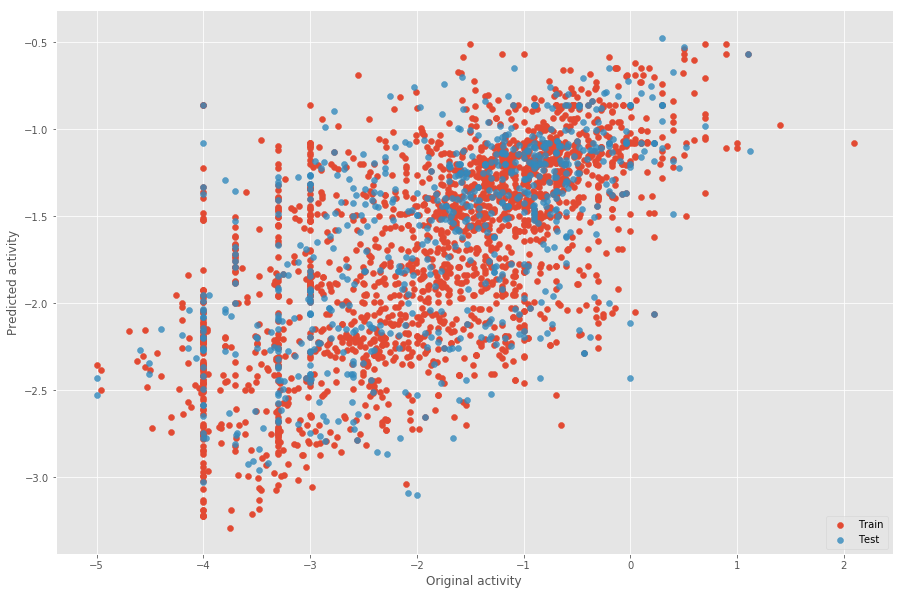

In [37]:
plot2(yTrain, xTrain, yTest, xTest, svm)

In [38]:
allRes[5] = outStat(svm, "svmMorgan")
allRes[5]

,name,R^2,correlation,MSE
0,svmMorgan,0.347679,0.624153,0.910959


# Pomuze preprocess?

In [39]:
from sklearn.decomposition import PCA

In [40]:
std = StandardScaler().fit_transform(morgFPs)

In [41]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(std)

#principalDf = pd.DataFrame(data = principalComponents
#             , columns = ['PC 1', 'PC 2', 'PC 3'])

In [42]:
xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(principalComponents, pvals, test_size = 0.25, random_state = 7)

In [43]:
rndForestReg = ensemble.RandomForestRegressor()
rndForestReg.fit(xTrain,yTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

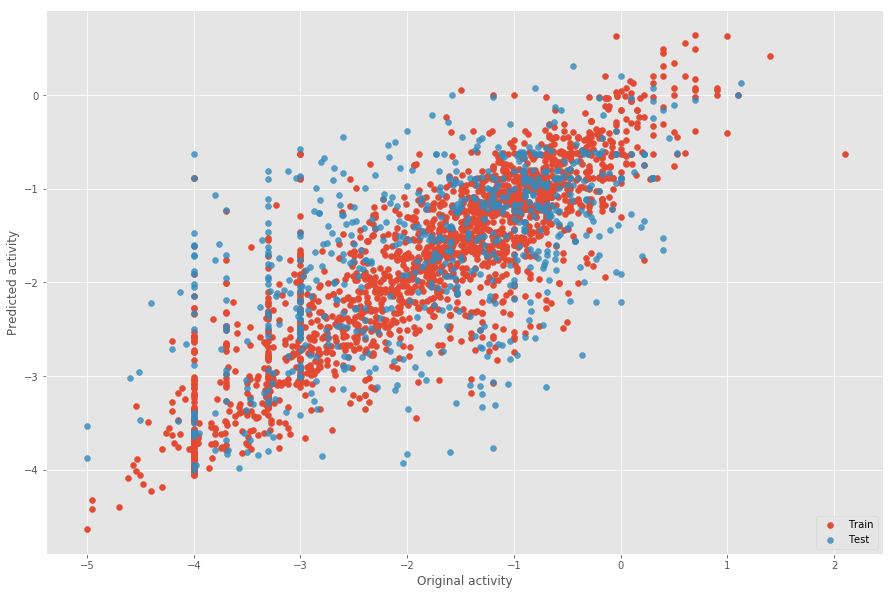

In [44]:
plot2(yTrain, xTrain, yTest, xTest, rndForestReg)

In [45]:
# preproces nepomohl
allRes[6] = outStat(rndForestReg, "rndForPreprocessedmorgFPs")
allRes[6]

,name,R^2,correlation,MSE
0,rndForPreprocessedmorgFPs,0.334517,0.602614,0.929339


# vysledky

In [46]:
vysledky = pd.concat(allRes, ignore_index=True)
vysledky

,name,R^2,correlation,MSE
0,rndForMQN,0.412634,0.655801,0.820250
1,svmMQN,0.453639,0.682751,0.762987
2,rndForMACC,0.450665,0.679516,0.767140
3,svmMACC,0.372119,0.622104,0.876828
4,rndForMorgan,0.427196,0.668259,0.799914
5,svmMorgan,0.347679,0.624153,0.910959
6,rndForPreprocessedmorgFPs,0.334517,0.602614,0.929339


# ___________________________________

# MORGAN FP - neural network

In [47]:
#x1 = [m[0] for m in fpsMol]
#x = np.array(list(x1))

In [48]:

x = np.array(list(morgFPs))
#x = np.array(list(maccs))
#x = np.array(list(mqns))
y = np.array(pvals) 

stdS = StandardScaler()
x = stdS.fit_transform(x)
print(np.shape(y))
print(np.shape(x))


(2763,)
(2763, 1024)


C:\ProgramData\Miniconda3\envs\cdd2018\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [49]:
xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(x, y, test_size = 0.25, random_state = 7)
print(np.shape(xTrain))

(2072, 1024)


In [50]:
model = Sequential()
model.add(Dense(output_dim=90, input_dim=x.shape[1]))
model.add(Activation("sigmoid"))
model.add(Dense(output_dim=1))
model.add(Activation("linear"))

C:\ProgramData\Miniconda3\envs\cdd2018\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=1024, units=90)`
  
C:\ProgramData\Miniconda3\envs\cdd2018\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  after removing the cwd from sys.path.


In [51]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                92250     
_________________________________________________________________
activation_1 (Activation)    (None, 90)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 91        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 92,341
Trainable params: 92,341
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.8, nesterov=True))
#model.compile(loss='mse', optimizer="rmsprop")
#model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.8, nesterov=True), metrics = ["accuracy"]) 

history = model.fit(xTrain, yTrain, epochs=100, batch_size=32, verbose = 0)
yPred = model.predict(xTest)

In [53]:
#results = model.fit(xTrain, yTrain,epochs= 100,batch_size = 500,validation_data = (xTest, yTest))

In [54]:
yPred[:4], yTest[:4]

(array([[ 0.42326173],
        [-0.9200527 ],
        [-1.1373018 ],
        [-1.0873127 ]], dtype=float32),
 array([ 0.69897   , -0.95999484, -0.        , -1.        ]))

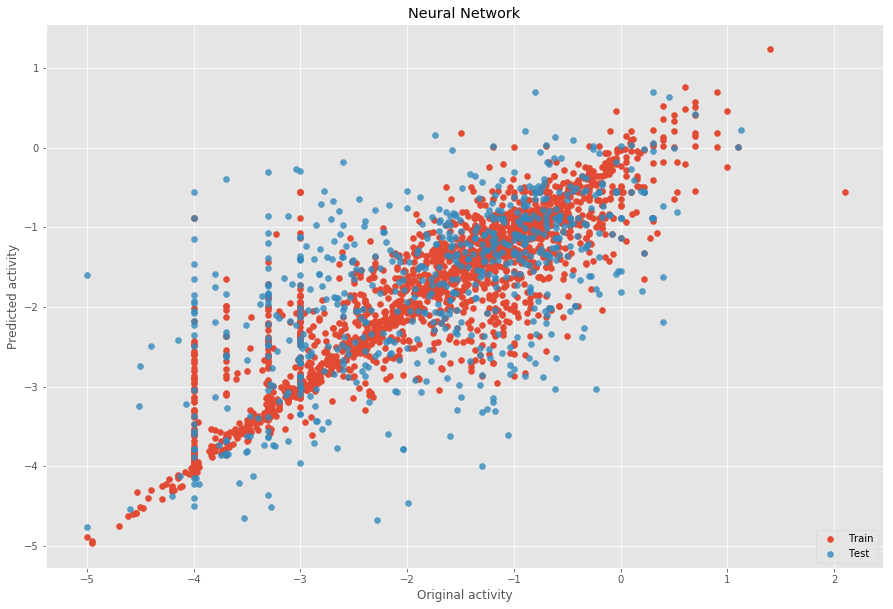

In [55]:
plot2(yTrain, xTrain, yTest, xTest, model, "Neural Network")

In [56]:
print("MSE - train: %0.2f" %  mean_squared_error(model.predict(xTrain), yTrain))
print("MSE - test: %0.2f" %  mean_squared_error(model.predict(xTest), yTest))

MSE - train: 0.29
MSE - test: 0.98


In [57]:
np.shape(yTrain), np.shape(model.predict(xTrain))
predictedTrain = model.predict(xTrain)
train = []
for i in range(0, len(predictedTrain)):
    train.append(predictedTrain[i][0])

In [58]:
predictedTest = model.predict(xTest)
test = []
for i in range(0, len(predictedTest)):
    test.append(predictedTest[i][0])    

In [59]:
# podobne vysledky jako v predchozich modelech
print("correlation - train: %0.2f" %  np.corrcoef(train, yTrain)[0][1])
print("correlation - test: %0.2f" %  np.corrcoef(test, yTest)[0][1])

correlation - train: 0.89
correlation - test: 0.61


# ___________________________________________________________________________________________________

# NN na datech rozdelenych do kategorii podle aktivity

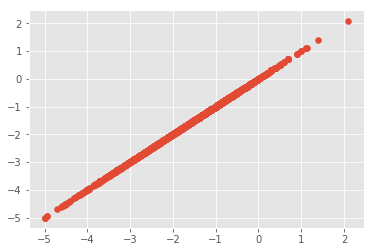

In [60]:
plt.scatter(pvals, pvals)

In [61]:
#8 kategorii, osmou zahazuji

(2762, 2763, 2762)

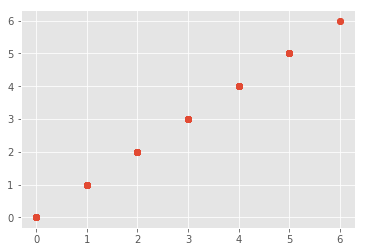

In [62]:
categories =[]
for val in pvals:
    categories.append((math.floor(val)+5))

categories.pop(-1)
plt.scatter(categories, categories)
len(fpsMol[:-1]), len(fpsMol), len(categories)

In [63]:
#vzhledem k bidnym vysledkum jsem tuto cast smazala

# pokus: binarni rozdeleni, aktivni vs neaktivni

In [64]:
# prevedeni na binarni hodnoty, 1 neaktivni / 0 aktivni, tu posledni molekulu stale nechavam odstranenou
category = [1 if val>2 else 0 for val in categories]

In [65]:
#std = StandardScaler().fit_transform(maccs[:-1])
#pca = PCA(n_components=3)
#principalComponents = pca.fit_transform(std)

In [66]:
#x1 = [m[0] for m in fpsMol[:-1]]
#x = np.array(list(x1))
#x = np.array(list(morgFPs[:-1]))
x = np.array(list(maccs[:-1]))
#x = np.array(list(mqns[:-1]))
Xx = np.array(list(principalComponents))
y = np.array(category) 
#x = stdS.fit_transform(x)
xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(x, y, test_size = 0.25, random_state = 7)
stdS = StandardScaler().fit(xTrain)
xTrain = stdS.transform(xTrain)
xTest = stdS.transform(xTest)
print(np.shape(xTrain))
category[:4], xTrain

(2071, 167)


C:\ProgramData\Miniconda3\envs\cdd2018\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


([0, 0, 0, 0],
 array([[0.        , 0.        , 0.        , ..., 0.15567091, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.15567091, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.15567091, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.15567091, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.15567091, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.15567091, 0.        ,
         0.        ]]))

In [67]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=x.shape[1]))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [68]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])                   
model.fit(xTrain, yTrain,epochs=10, batch_size=1, verbose=1)

Epoch 1/10
2071/2071 [==============================] - 5s 2ms/step - loss: 0.5483 - acc: 0.7291
Epoch 2/10
2071/2071 [==============================] - 4s 2ms/step - loss: 0.4797 - acc: 0.7726
Epoch 3/10
2071/2071 [==============================] - 4s 2ms/step - loss: 0.4503 - acc: 0.7842
Epoch 4/10
2071/2071 [==============================] - 4s 2ms/step - loss: 0.4400 - acc: 0.7808
Epoch 5/10
2071/2071 [==============================] - 4s 2ms/step - loss: 0.4230 - acc: 0.7904
Epoch 6/10
2071/2071 [==============================] - 4s 2ms/step - loss: 0.4143 - acc: 0.7972
Epoch 7/10
2071/2071 [==============================] - 4s 2ms/step - loss: 0.4019 - acc: 0.7972
Epoch 8/10
2071/2071 [==============================] - 5s 2ms/step - loss: 0.3924 - acc: 0.8064
Epoch 9/10
2071/2071 [==============================] - 4s 2ms/step - loss: 0.3838 - acc: 0.8054
Epoch 10/10
2071/2071 [==============================] - 4s 2ms/step - loss: 0.3812 - acc: 0.8102


In [69]:
score = model.evaluate(xTest, yTest,verbose=1)
print(score)
print("accuracy: ", score[1])

691/691 [==============================] - 0s 162us/step
[0.48100513323343613, 0.7554269172520782]
accuracy:  0.7554269172520782


In [70]:
#neupravene hodnoty jsou pravdepodobnost jestli slo o label 1 - tj neaktivni molekulu, pak je upravuji na 1 / 0
pred = model.predict(xTest)
pred = [1 if val>0.5 else 0 for val in pred]
pred[:15], yTest[0:15]

([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
 array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]))

In [71]:
from sklearn.metrics import precision_score, accuracy_score

print("precision score: ",  precision_score(pred, yTest))
print("accuracy score: ",  accuracy_score(pred, yTest))

precision score:  0.8133971291866029
accuracy score:  0.7554269175108539


In [72]:
# kolikrat odhad vysel pro testovaci data?
all = pred + yTest
celkem = len(pred) - (all == 1).sum()
tabulka = pd.DataFrame([[len(pred), celkem, (all == 0).sum(), (all == 2).sum()]], columns=["celkem", "shodne", "neaktivni", "aktivni"])
tabulka

,celkem,shodne,neaktivni,aktivni
0,691,522,182,340


In [73]:
# trenovaci data, jen pro info


In [74]:
predTrain = model.predict(xTrain)
predTrain = [1 if val>0.5 else 0 for val in predTrain]
all = predTrain + yTrain
celkem = len(predTrain) - (all == 1).sum()
tabulka = pd.DataFrame([[len(predTrain), celkem, (all == 0).sum(), (all == 2).sum()]], columns=["celkem", "shodne", "neaktivni", "aktivni"])
tabulka

,celkem,shodne,neaktivni,aktivni
0,2071,1727,611,1116


In [75]:
print("precision score: ",  precision_score(predTrain, yTrain))
print("accuracy score: ",  accuracy_score(predTrain, yTrain))

precision score:  0.8780487804878049
accuracy score:  0.8338966682761951
